In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
import seaborn as sns

In [4]:
import os
import cv2
import numpy as np

int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise'}
emotions2int = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5}

dic = {'images':[], 'labels':[], 'purpose':[]}

for d in os.listdir('archive/'):
    path_d = os.path.join('archive', d)
    if not os.path.isdir(path_d):
        continue  # skip files like .DS_Store
    
    print(d)
    for emotion in os.listdir(path_d):
        path_emotion = os.path.join(path_d, emotion)
        if not os.path.isdir(path_emotion):
            continue
        
        print(emotion)
        for i in os.listdir(path_emotion):
            img_path = os.path.join(path_emotion, i)
            img = cv2.imread(img_path, 0)
            if img is None:
                continue  # skip corrupted or unreadable images
            
            img = img.reshape(48, 48, 1)
            dic['images'].append(img)
            dic['labels'].append(emotion)

            dic['purpose'].append('T' if d == 'train' else 'V')


train
happy
sad
fear
surprise
neutral
angry
validation
happy
sad
fear
surprise
neutral
angry


In [5]:
df = pd.DataFrame(dic)
df.head()

,images,labels,purpose
0,"[[[108], [83], [63], [65], [89], [111], [121],...",happy,T
1,"[[[137], [142], [159], [162], [158], [134], [1...",happy,T
2,"[[[111], [148], [155], [167], [181], [191], [1...",happy,T
3,"[[[151], [156], [121], [100], [80], [116], [15...",happy,T
4,"[[[248], [187], [149], [130], [97], [140], [13...",happy,T


In [6]:
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [7]:
train_data.head()

,images,labels,purpose
0,"[[[108], [83], [63], [65], [89], [111], [121],...",happy,T
1,"[[[137], [142], [159], [162], [158], [134], [1...",happy,T
2,"[[[111], [148], [155], [167], [181], [191], [1...",happy,T
3,"[[[151], [156], [121], [100], [80], [116], [15...",happy,T
4,"[[[248], [187], [149], [130], [97], [140], [13...",happy,T


In [8]:
val_data.head()

,images,labels,purpose
28273,"[[[5], [4], [5], [9], [10], [9], [10], [12], [...",happy,V
28274,"[[[19], [21], [22], [18], [20], [21], [16], [1...",happy,V
28275,"[[[228], [229], [230], [229], [228], [227], [2...",happy,V
28276,"[[[25], [33], [43], [30], [46], [84], [105], [...",happy,V
28277,"[[[33], [29], [15], [15], [20], [36], [40], [5...",happy,V


In [9]:
train_data['labels'].value_counts()

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
Name: labels, dtype: int64

In [10]:
val_data['labels'].value_counts()

happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
Name: labels, dtype: int64

In [ ]:
happy_df = train_data[train_data['labels']=='happy'].sample(n=3171)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=3171)
sad_df = train_data[train_data['labels']=='sad'].sample(n=3171)
fear_df = train_data[train_data['labels']=='fear'].sample(n=3171)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3171)
surprise_df = train_data[train_data['labels']=='surprise'].sample(n=3171)
#repeat for all classes, then combine and shuffle
train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose
0,"[[[124], [82], [26], [13], [8], [15], [46], [9...",sad,T
1,"[[[137], [74], [44], [56], [87], [147], [141],...",fear,T
2,"[[[214], [196], [201], [207], [209], [220], [2...",sad,T
3,"[[[181], [181], [173], [106], [128], [168], [1...",sad,T
4,"[[[104], [142], [135], [150], [171], [193], [2...",neutral,T


In [12]:
train_data['labels'].value_counts()

sad         3171
fear        3171
neutral     3171
happy       3171
surprise    3171
angry       3171
Name: labels, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

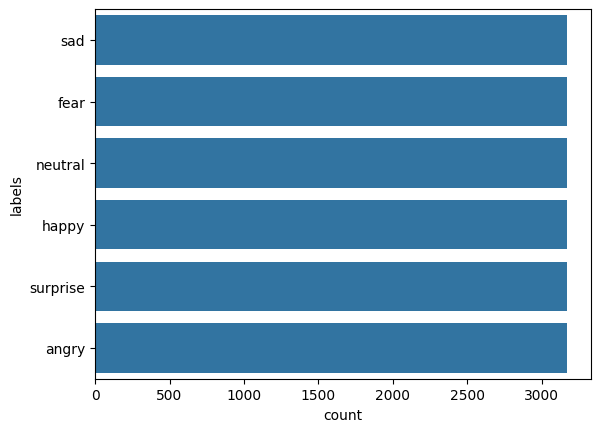

In [13]:
sns.countplot(train_data['labels'])

In [14]:
batch_size= 32
classes = 6
rows,columns=48,48

In [ ]:


# Map labels to integers
train_labels = train_data['labels'].map(emotions2int)
val_labels = val_data['labels'].map(emotions2int)

# Check for NaN values after mapping
if train_labels.isna().sum() > 0:
    print("Warning: Some labels were not mapped correctly. Check your label names.")

# Convert to categorical
train_labels = to_categorical(train_labels, num_classes=classes)
val_labels = to_categorical(val_labels, num_classes=classes)





In [16]:
train_data = list(train_data['images'])
train_data = np.array(train_data)

val_data = list(val_data['images'])
val_data = np.array(val_data)

In [17]:
train_data.shape

(19026, 48, 48, 1)

In [18]:
val_data.shape

(7067, 48, 48, 1)

In [19]:
batch_size= 32
classes = 6
rows,columns=48,48

train_dir = 'archive/train' 
validation_dir = 'archive/validation'

train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=45,
                              height_shift_range=0.3,
                              width_shift_range=0.3,
                              shear_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

validation_gen = ImageDataGenerator(rescale=1./255)

training_data_generator = train_gen.flow_from_directory(train_dir,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       color_mode='grayscale',
                                                       class_mode='categorical',
                                                       target_size=(rows,columns))

valiadtion_data_generator = validation_gen.flow_from_directory(validation_dir,
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       color_mode='grayscale',
                                                       class_mode='categorical',
                                                       target_size=(rows,columns))




Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


## Creating Our Model

In [ ]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

2025-04-28 12:00:57.891945: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-28 12:00:57.892128: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-28 12:00:57.892133: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-28 12:00:57.892379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-28 12:00:57.892800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

In [21]:
checkpoint = ModelCheckpoint('model/6_class_emotion_detector_V2.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

train_samples = 28273
validation_samples = 3534
batch_size = 64
epochs=30

# Training Our Model

In [22]:
history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/30


2025-04-28 12:01:13.993784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - ETA: 0s - loss: 2.2094 - accuracy: 0.1854
Epoch 1: val_loss improved from inf to 1.87157, saving model to model/6_class_emotion_detector_V2.h5
441/441 [==============================] - 108s 237ms/step - loss: 2.2094 - accuracy: 0.1854 - val_loss: 1.8716 - val_accuracy: 0.2152
Epoch 2/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


441/441 [==============================] - ETA: 0s - loss: 1.7159 - accuracy: 0.2805
Epoch 2: val_loss improved from 1.87157 to 1.74225, saving model to model/6_class_emotion_detector_V2.h5
441/441 [==============================] - 106s 240ms/step - loss: 1.7159 - accuracy: 0.2805 - val_loss: 1.7423 - val_accuracy: 0.2964
Epoch 3/30
441/441 [==============================] - ETA: 0s - loss: 1.4622 - accuracy: 0.4099
Epoch 3: val_loss improved from 1.74225 to 1.38900, saving model to model/6_class_emotion_detector_V2.h5
441/441 [==============================] - 108s 245ms/step - loss: 1.4622 - accuracy: 0.4099 - val_loss: 1.3890 - val_accuracy: 0.4481
Epoch 4/30
441/441 [==============================] - ETA: 0s - loss: 1.3110 - accuracy: 0.4861
Epoch 4: val_loss improved from 1.38900 to 1.30820, saving model to model/6_class_emotion_detector_V2.h5
441/441 [==============================] - 108s 245ms/step - loss: 1.3110 - accuracy: 0.4861 - val_loss: 1.3082 - val_accuracy: 0.4910
Epo

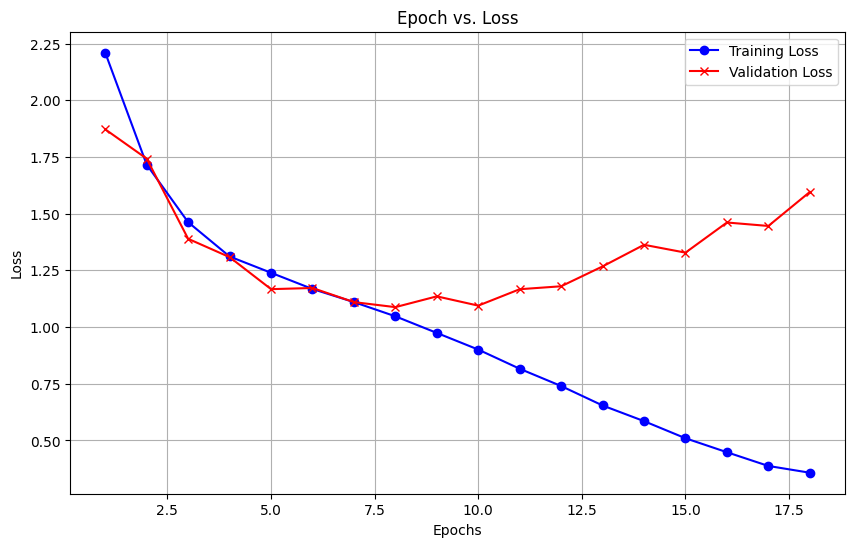

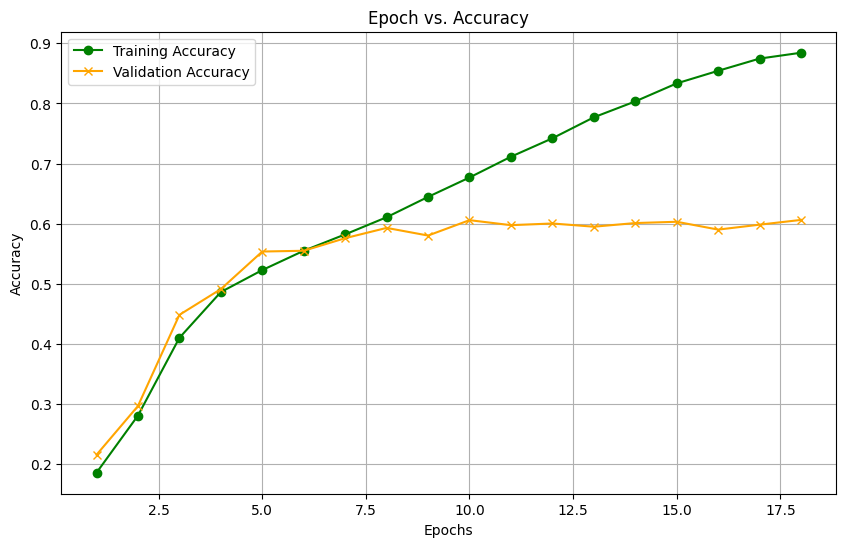

In [24]:
import matplotlib.pyplot as plt

# Get the number of epochs from the length of the loss history
num_epochs = len(history.history['loss'])  # Or len(history.history['accuracy'])

# Define the epochs range
epochs = range(1, num_epochs + 1)

# Extract loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='x')
plt.title('Epoch vs. Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', marker='x')
plt.title('Epoch vs. Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
